In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm
importlib.reload(kgs);

local
local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)
data = train_data[0]

CPU times: user 485 ms, sys: 76.9 ms, total: 562 ms
Wall time: 1.74 s


In [3]:
#(data,inferred_data) = kgs.dill_load(kgs.temp_dir + '/test_simple.pickle')

In [4]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    print(a,b)
    return rms

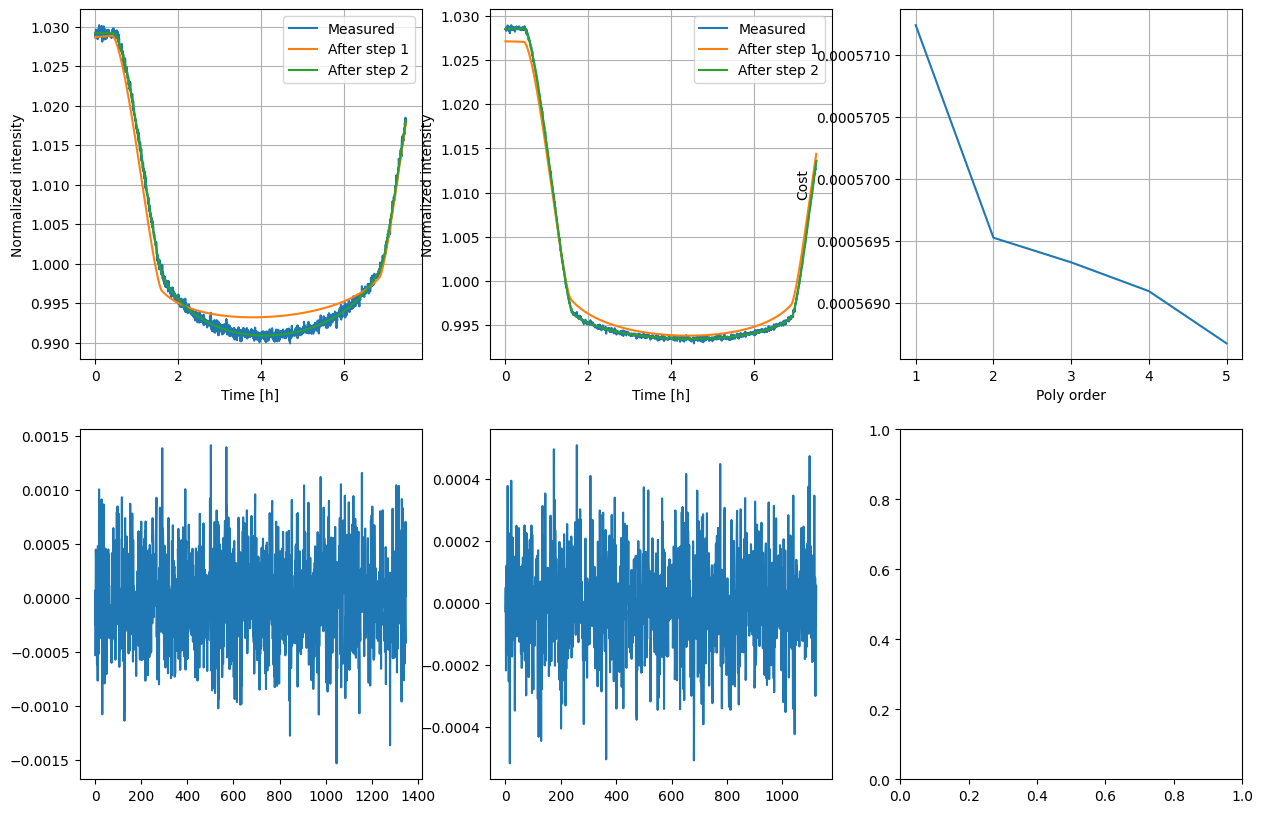

0.9938754472840563 [0.00018705]


In [5]:
data,inferred_data,kgs.sanity_checks = kgs.dill_load(kgs.temp_dir + '/test_simple.pickle')
kgs.sanity_checks_without_errors = True
import ariel_simple
importlib.reload(ariel_simple)
ind=np.argsort(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all)[-5]
for dd in [train_data[ind]]:#[train_data[0], train_data[ind]]:
    data = [dd]
    data[0].planet_id = train_data[ind].planet_id
    data[0].spectrum = train_data[ind].spectrum    
    model = ariel_simple.SimpleModel()     
    model.do_plots = True
    model.train(train_data)
    #model.weights=[0.,1.]
    #model.limb_dark = 'nonlinear'
    #model.u_init = [[0.1 for i in range(4)] for j in range(2)]
    #print(model.u)
    #data[0].load_to_step(0,model.loaders)        
    #data[0].load_to_step(5,model.loaders)                         
    #for ii in range(2):
    #    model.loaders[ii].apply_pixel_corrections.remove_first_and_last_frame = True
    #data[0].transits[0].data[1].times = data[0].transits[0].data[1].times[:-1]
    #data[0].transits[0].data[1].time_intervals = data[0].transits[0].data[1].time_intervals[:-1]
    #data[0].transits[0].data[1].data = data[0].transits[0].data[1].data[:-1,:]
    #data = [train_data[ind]]
    inferred_data = model.infer(data)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all[-1], np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

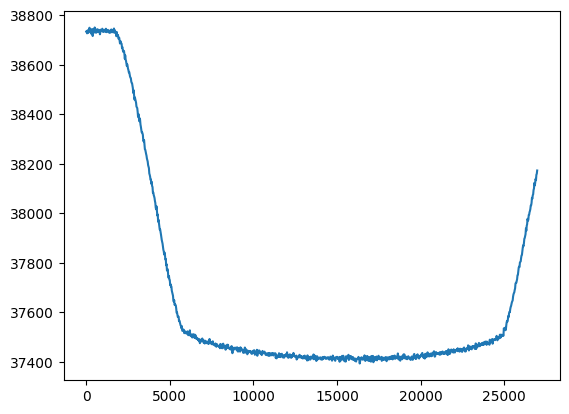

In [6]:
inferred_data[0].load_to_step(5,model.loaders)
plt.figure();plt.plot(inferred_data[0].transits[0].data[1].times.get(), np.mean(inferred_data[0].transits[0].data[1].data.get(),1));

In [75]:
np.mean(inferred_data[0].transits[0].data[1].data.get(),1)[-5:]

array([38177.57474354, 38186.20021169, 38184.75557381, 38162.23609336,
       38733.36204033])

In [18]:
score, rms_err = kgs.score_metric(inferred_data, data)
#np.sqrt(np.diag(inferred_data[0].spectrum_cov))

TypeError: 'Planet' object is not iterable

In [7]:
import copy
data_sim = copy.deepcopy(data)
sig = rms_err
for ii,d in enumerate(data_sim):
    d.spectrum += np.random.default_rng(seed=ii).normal(0,sig,size=d.spectrum.shape)
    d.spectrum_cov = np.diag(0*d.spectrum+sig**2)
    d.check_constraints()
print('Theoretical')
kgs.score_metric(data_sim, data);

Theoretical
Score:     0.3823
RMS error: 501.8123 ppm


In [25]:
data

[Planet(planet_id=3326797063, is_train=True, Rs=0.9310100746217564, Ms=0.8758432302557226, Ts=5540.088113442507, Mp=0.9438478952643332, e=0.0, P=7.504197697856942, sma=18.428815922759604, i=90.0, spectrum=array([0.02101458, 0.02108453, 0.02107777, 0.02106513, 0.02105282,
        0.0210468 , 0.02104845, 0.02105335, 0.02105483, 0.02104939,
        0.02103876, 0.02102706, 0.02101666, 0.0210074 , 0.02099913,
        0.0209929 , 0.02098955, 0.02098854, 0.02098883, 0.02099033,
        0.02099348, 0.02099848, 0.02100541, 0.02101473, 0.02102685,
        0.02104135, 0.02105755, 0.02107626, 0.02109901, 0.02112398,
        0.02114378, 0.02115181, 0.02115069, 0.02115073, 0.02115821,
        0.02116932, 0.02117749, 0.02118269, 0.02118987, 0.02120044,
        0.0212095 , 0.02121194, 0.02120873, 0.02120639, 0.02121075,
        0.02122103, 0.02123059, 0.02123403, 0.02123322, 0.02123397,
        0.02123685, 0.02123455, 0.02122088, 0.0212001 , 0.02118268,
        0.02117366, 0.02116967, 0.02116633, 0.02

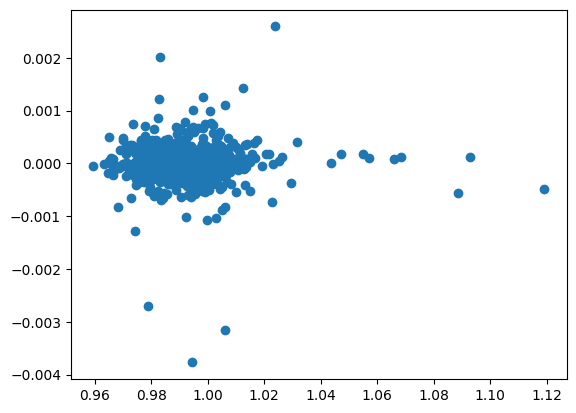

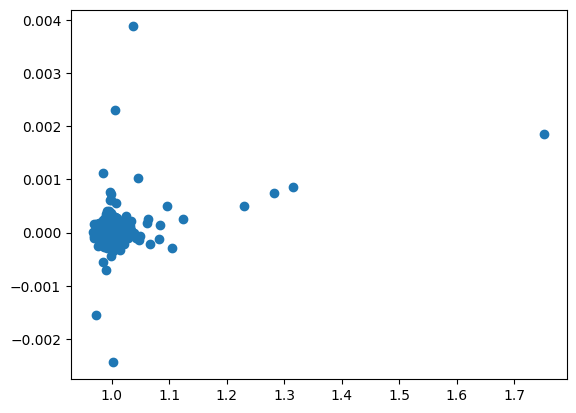

In [17]:
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_ratio_FGS'].seen_all, solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all, np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

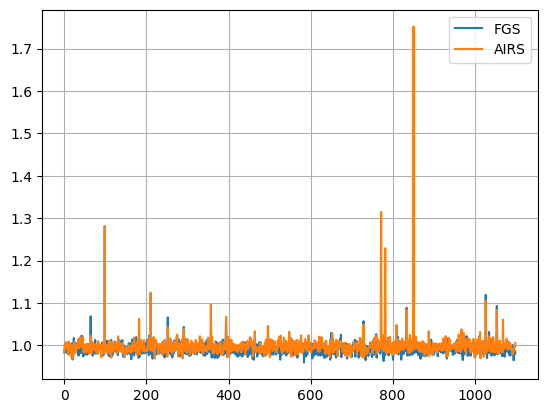

In [9]:
plt.figure()
plt.plot(kgs.sanity_checks['simple_residual_ratio_FGS'].seen_all)
plt.plot(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all)
plt.legend(('FGS', 'AIRS'))
plt.grid(True)

In [10]:
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)


In [11]:
kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()),kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy())

(0.0003130963725749593, 0.0005028031357932226)

Text(0.5, 1.0, '502.8031357932226')

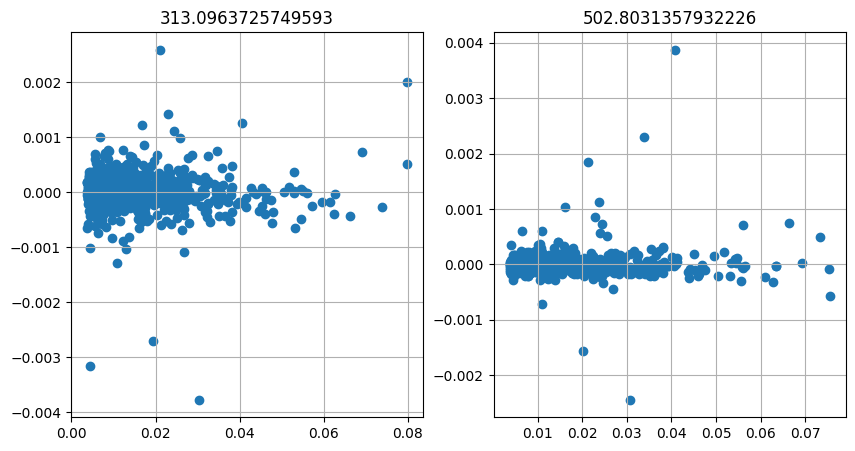

In [12]:
_,ax=plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
plt.box(True);plt.grid(True);
plt.scatter(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.title(1e6*kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()))
plt.sca(ax[1])
plt.box(True);plt.grid(True);
plt.scatter(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))
plt.title(1e6*kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy()))

In [13]:
ind = np.argmax(np.abs(np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1)))
ind

968

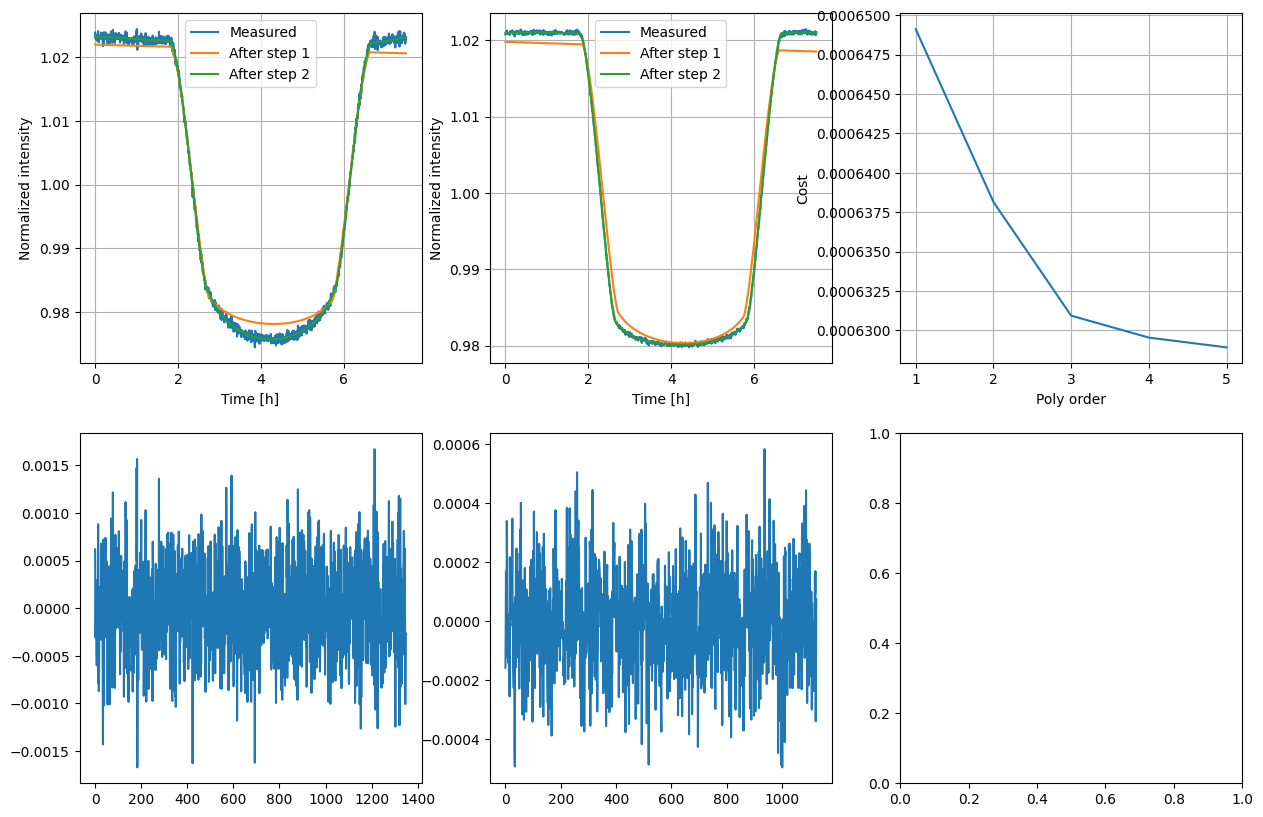

[1.1576735485299767, 1.1343814632411002]
0.0008749024930100255 0.0037660491029036626 0.00016395281231290488


In [14]:
import ariel_simple
import copy
kgs.sanity_checks_active = False
importlib.reload(ariel_simple)
ind=968
model = ariel_simple.SimpleModel()
model.run_in_parallel = False
model.do_plots = True
model.use_correction_factor = True
model.train(train_data)
data = copy.deepcopy(train_data[ind:ind+1])
#kgs.list_attrs(data[0])
# for d_ref in train_data:
#     dat = copy.deepcopy(d_ref)
#     dat.spectrum = train_data[ind].spectrum
#     dat.planet_id = train_data[ind].planet_id
#     data = [dat]
    #data[0].sma = sma
    #for ii in range(2):
    #    pass
       #model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False    
       #model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False    
     #   model.loaders[ii].apply_pixel_corrections.mask_hot = False
     #   model.loaders[ii].apply_pixel_corrections.mask_hot = False
inferred_data = model.infer(data)
print(model.correction_factor)
print(np.mean(data[0].spectrum[:1]-inferred_data[0].spectrum[:1]), np.mean(data[0].spectrum[1:]-inferred_data[0].spectrum[1:]), kgs.rms(model.pred[1]-model._targets[1]))